**Time Series Analysis - Project 2: LSTM (Long Short-Term Memory)**

**Model Accuracy: 95.55% (non-rolling), 93.19 % (rollling)** <br>
**In this project we will be predicting sales data using ** <br>
**The dataset can be found here: https://github.com/ritvikmath/Time-Series-Analysis/blob/master/catfish.csv**

**Importing libaries**

In [33]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt
from kerastuner.tuners import BayesianOptimization
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

**importing the dataset**

In [34]:
df = pd.read_csv("/Users/willbarnard/Downloads/catfish.csv", parse_dates=[0], index_col=[0], date_format = '%Y-%m-%d')

start_date = datetime.datetime(1986, 1, 1)
end_date = datetime.datetime(2004, 1, 1)
lim_df = df[start_date:end_date]


data = lim_df[['Total']]
data = data.sort_index()

**Performing exploratory data anlysis**

In [35]:
data.head()

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 1986-01-01 to 2004-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Total   217 non-null    int64
dtypes: int64(1)
memory usage: 3.4 KB


In [37]:
data.describe()

,Total
count,217.000000
mean,19392.400922
std,5253.746842
min,8196.000000
25%,15486.000000
50%,19500.000000
75%,23576.000000
max,30485.000000


**Scaling inputs to a fixed range**

In [38]:
scalar = MinMaxScaler()
data['Scaled'] = scalar.fit_transform(data[['Total']])

**Visualising the scaled data**

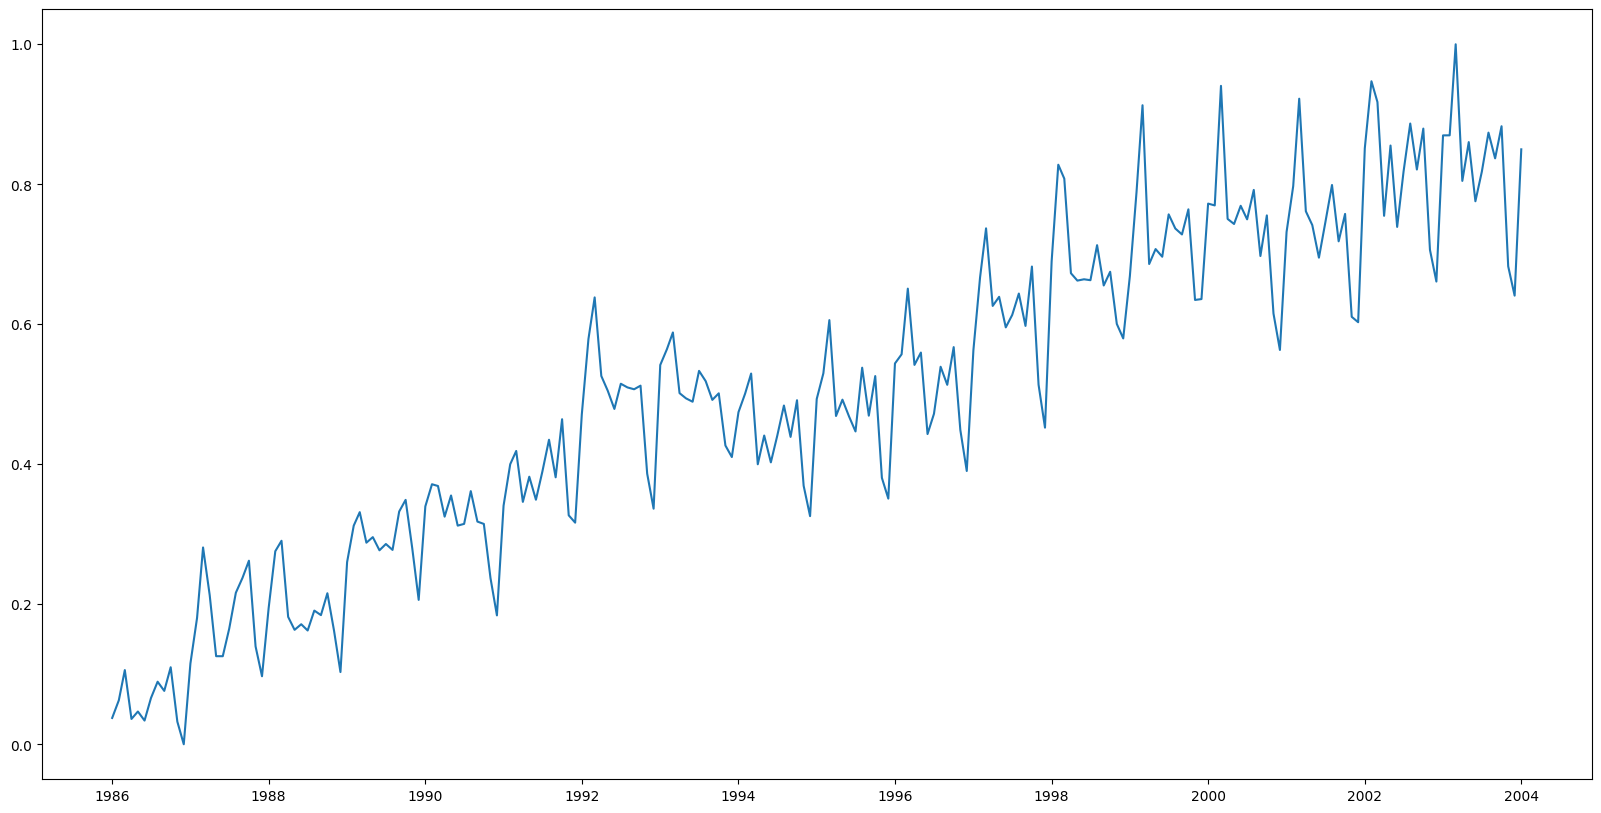

In [39]:
plt.figure(figsize=(20,10))
plt.plot(data['Scaled'], label='Scaled Sales')
plt.show()

**Creating sequences of data**

In [40]:
SEQ_LENGTH = 12
def create_sequences(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i + window])
        y.append(series[i + window])
    return np.array(X), np.array(y)

series = data['Scaled'].values
X, y = create_sequences(series, SEQ_LENGTH)
X = X.reshape((X.shape[0], X.shape[1], 1))

**Splitting the sequences into training and testing**

In [41]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

**Creating the LSTM model**

In [43]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32),
                   return_sequences=False,
                   input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='mse'
    )
    return model


**Performing Bayesian Hyperparameter Optimisation**

In [47]:
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',  # what to minimize (e.g. validation loss)
    max_trials=10,         # number of different models to try
    executions_per_trial=1,
    directory='my_dir',    # where to save logs and results
    project_name='lstm_bayesian_tuning'
)

Reloading Tuner from my_dir/lstm_bayesian_tuning/tuner0.json


In [49]:
tuner.search(X_train, y_train, 
             epochs=20, 
             validation_split=0.2, 
             batch_size=3,
             verbose=1)


In [50]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best units: {best_hp.get('units')}")
print(f"Best dropout: {best_hp.get('dropout')}")
print(f"Best learning rate: {best_hp.get('lr')}")

best_model = tuner.get_best_models(num_models=1)[0]


Best units: 224
Best dropout: 0.2
Best learning rate: 0.003366336681373164


/Users/willbarnard/tf-env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [51]:
history = best_model.fit(X_train, y_train, epochs=1000, batch_size=8, validation_split=0.1, verbose=1)

Epoch 1/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 2/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0058 - val_loss: 0.0085
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067 - val_loss: 0.0054
Epoch 5/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - val_loss: 0.0051
Epoch 6/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0066 - val_loss: 0.0252
Epoch 7/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0091 - val_loss: 0.0053
Epoch 8/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0054 - val_loss: 0.0107
Epoch 9/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0061 - val_loss: 0.0054
Epoch 10/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 11/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0061 - val_loss: 0.0092
Epoch 12/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 

**Visualising the training performance**

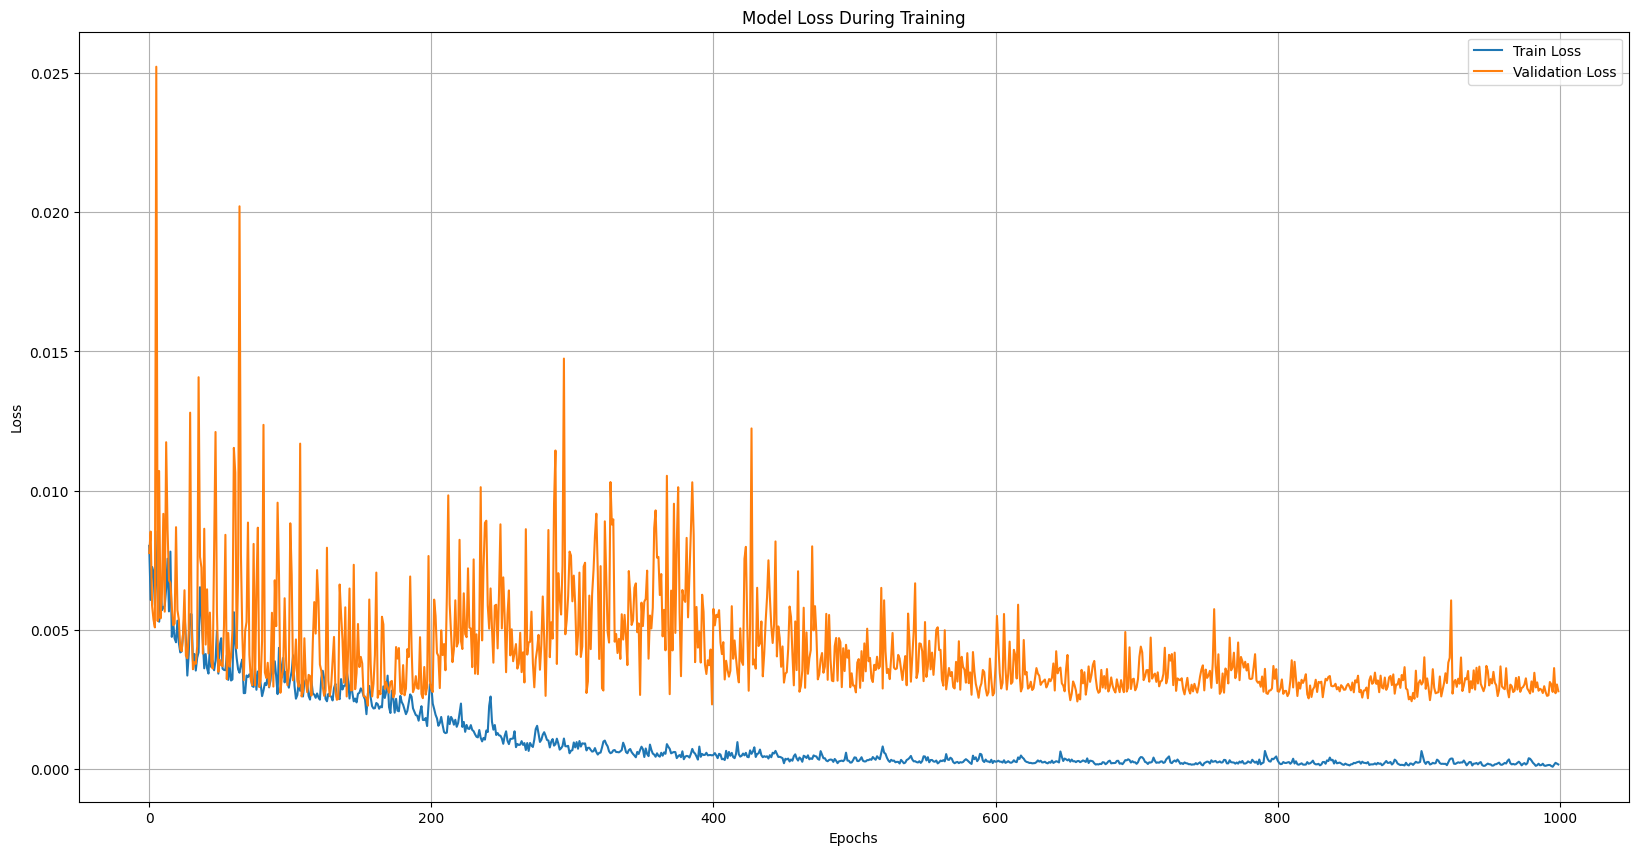

In [52]:
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Calculating predictions**

In [53]:
predictions = best_model.predict(X_test)
pred_rescaled = scalar.inverse_transform(predictions)
y_test_rescaled = scalar.inverse_transform(y_test.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


**Calculating residuals (errors)**

In [54]:
residuals = y_test_rescaled - pred_rescaled

**Visualising the residuals (errors)**

Text(0, 0.5, 'Error')

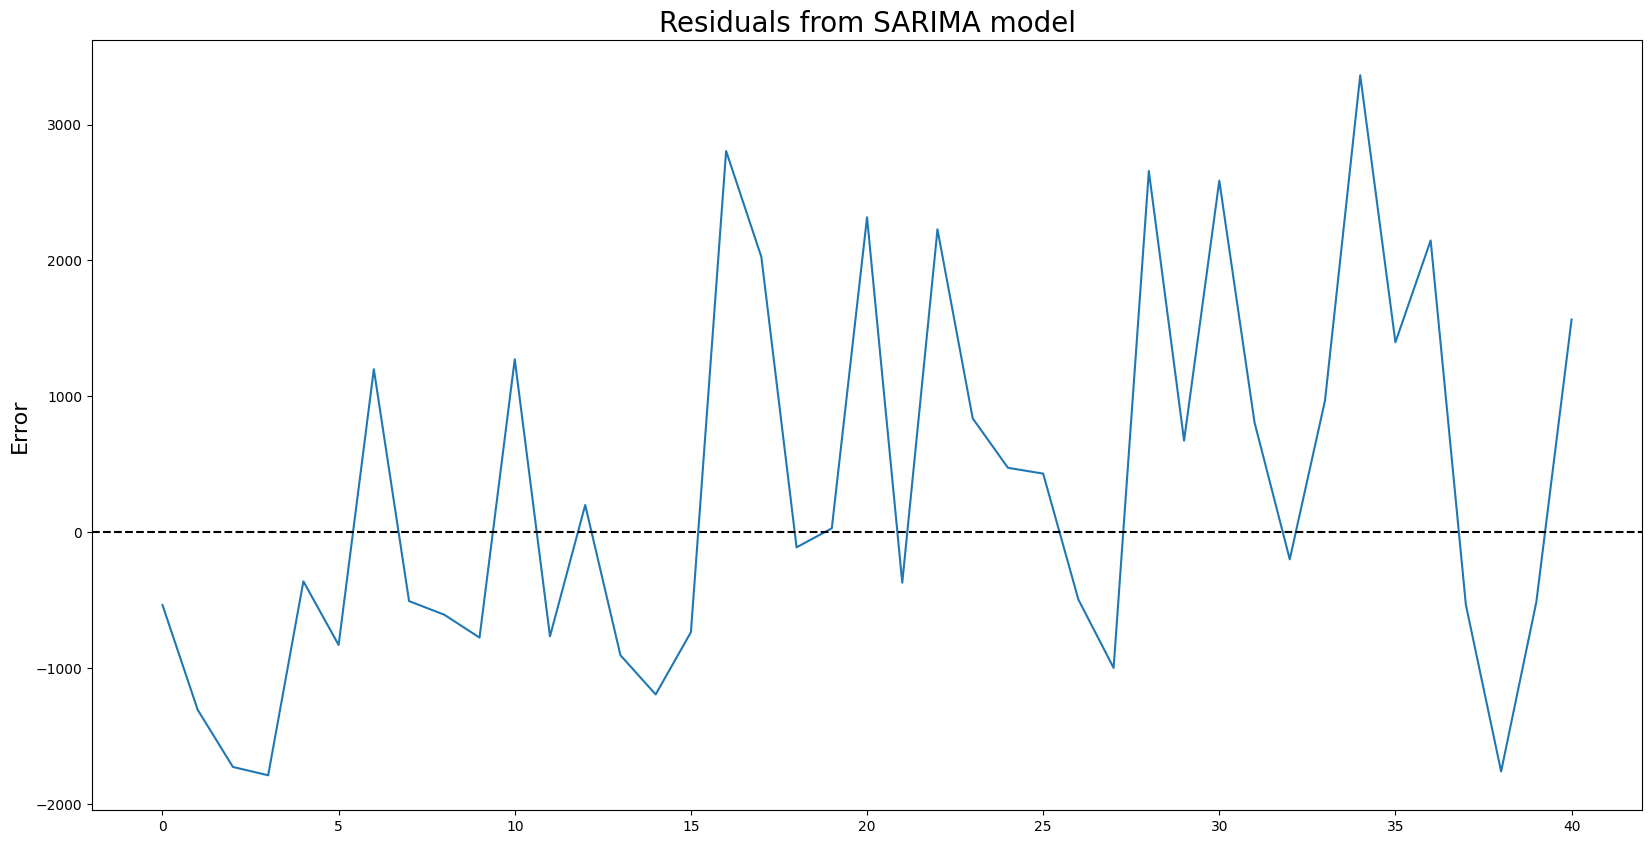

In [55]:
plt.figure(figsize=(20,10))
plt.plot(residuals)
plt.axhline(0, linestyle = '--', color='k')
plt.title('Residuals from SARIMA model', fontsize=20)
plt.ylabel('Error', fontsize=16)

**Visualising the disitribution of errors**

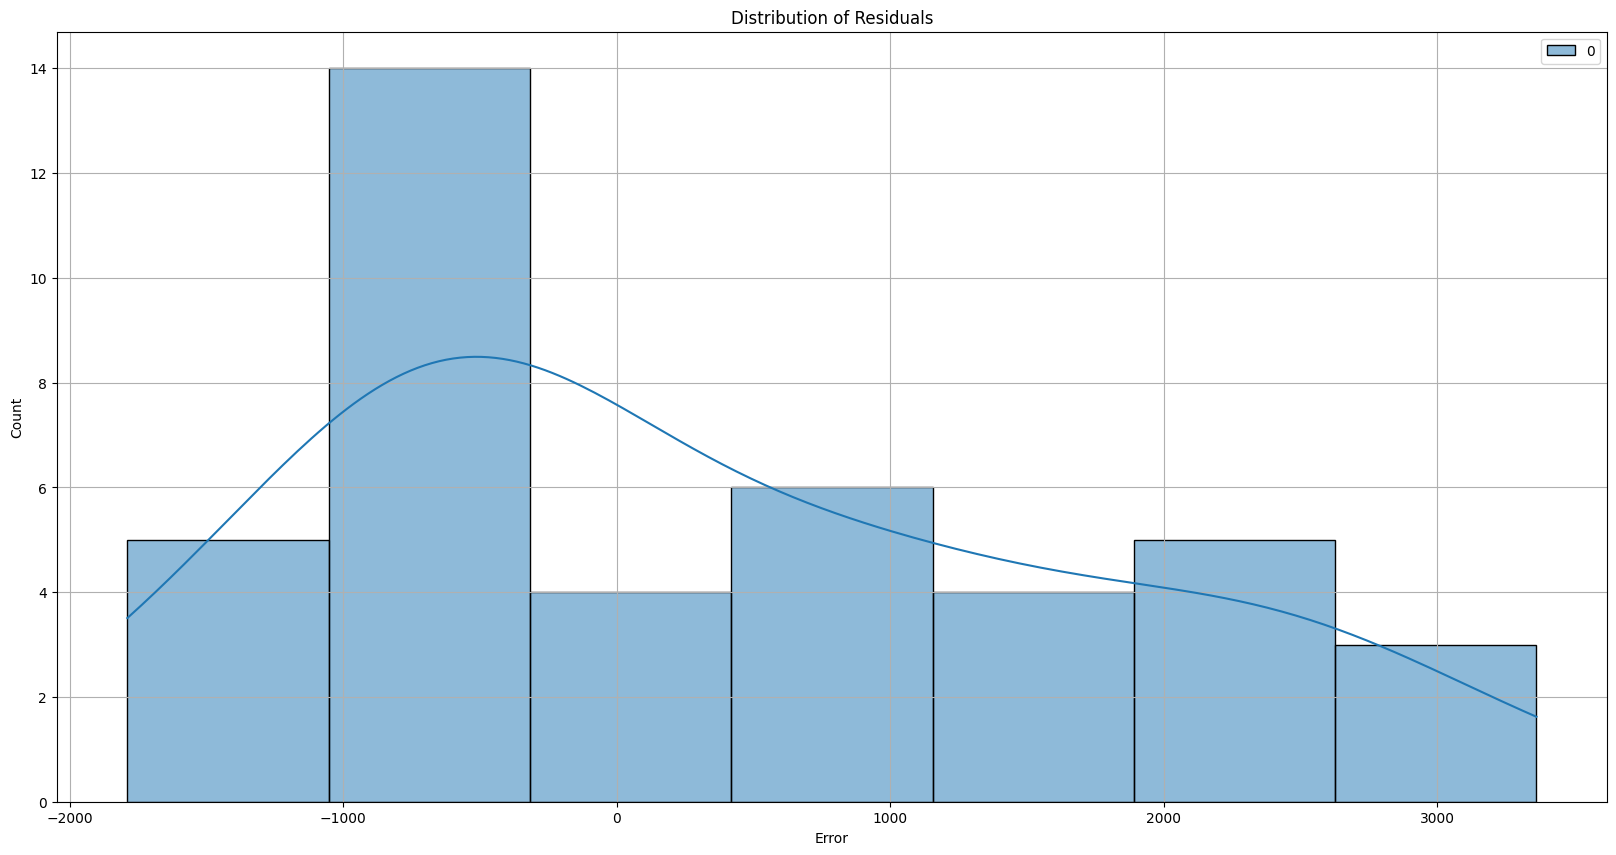

In [56]:
plt.figure(figsize=(20,10))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Error")
plt.grid(True)
plt.show()

**Calculating MAPE error metric**

In [57]:
print('Mean Absolute Percent error: ', round(np.mean(abs(residuals/y_test_rescaled)), 4))

Mean Absolute Percent error:  0.0445


**Displaying the model's predictions**

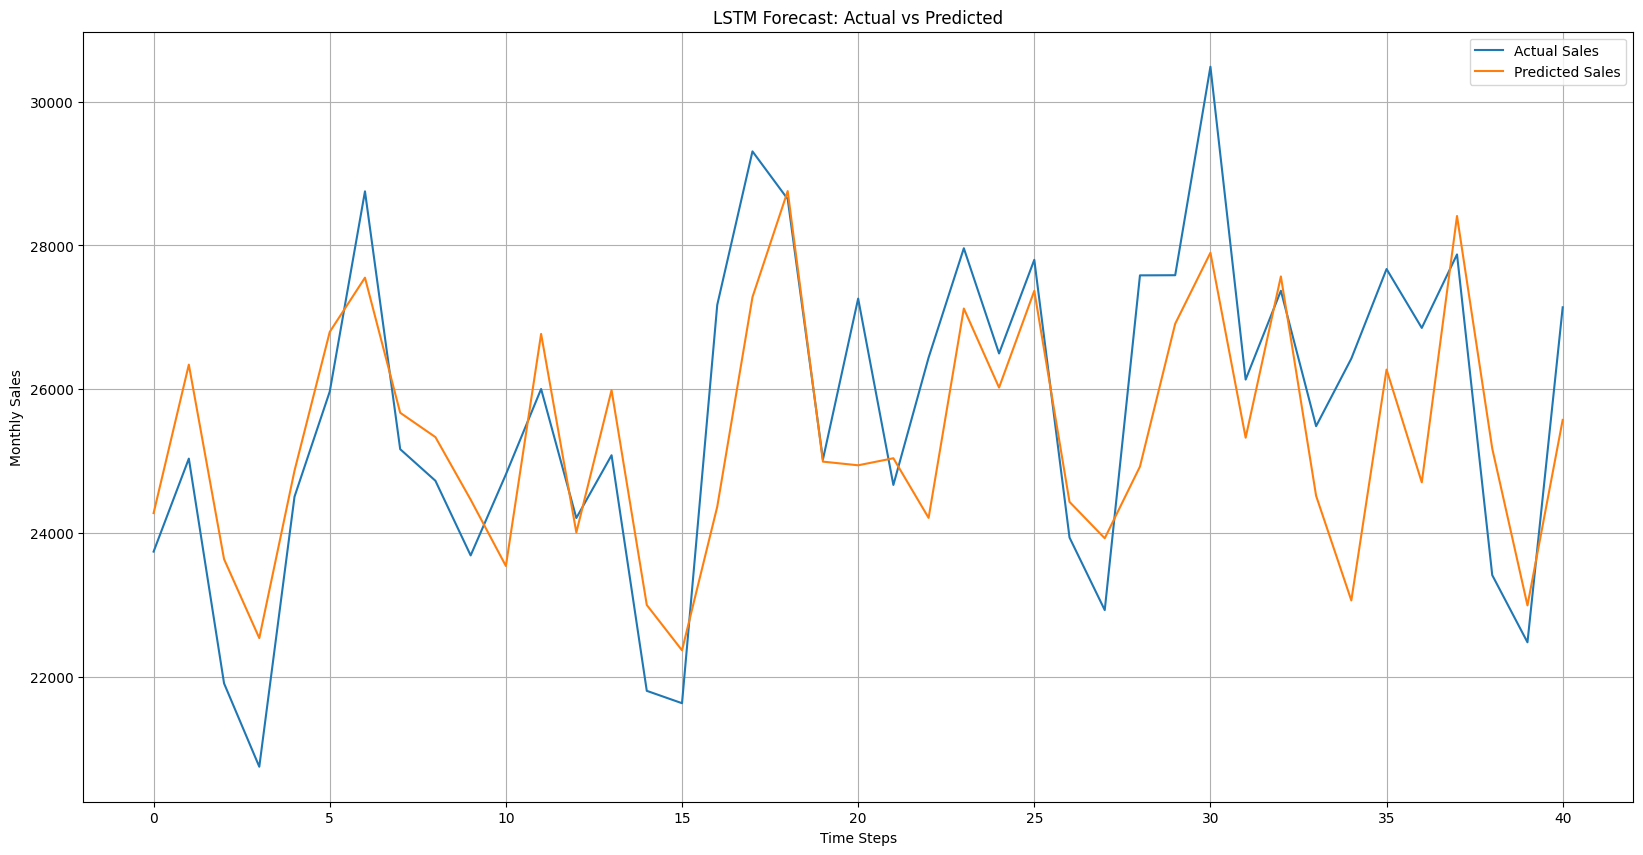

In [58]:
plt.figure(figsize=(20, 10))
plt.plot(y_test_rescaled, label='Actual Sales')
plt.plot(pred_rescaled, label='Predicted Sales')
plt.title("LSTM Forecast: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Monthly Sales")
plt.legend()
plt.grid(True)
plt.show()

**Extracting the orginal training labels**

In [59]:
y_train_rescaled = scalar.inverse_transform(y_train.reshape(-1, 1))

**Plotting the entire dataset as well as the predictions**

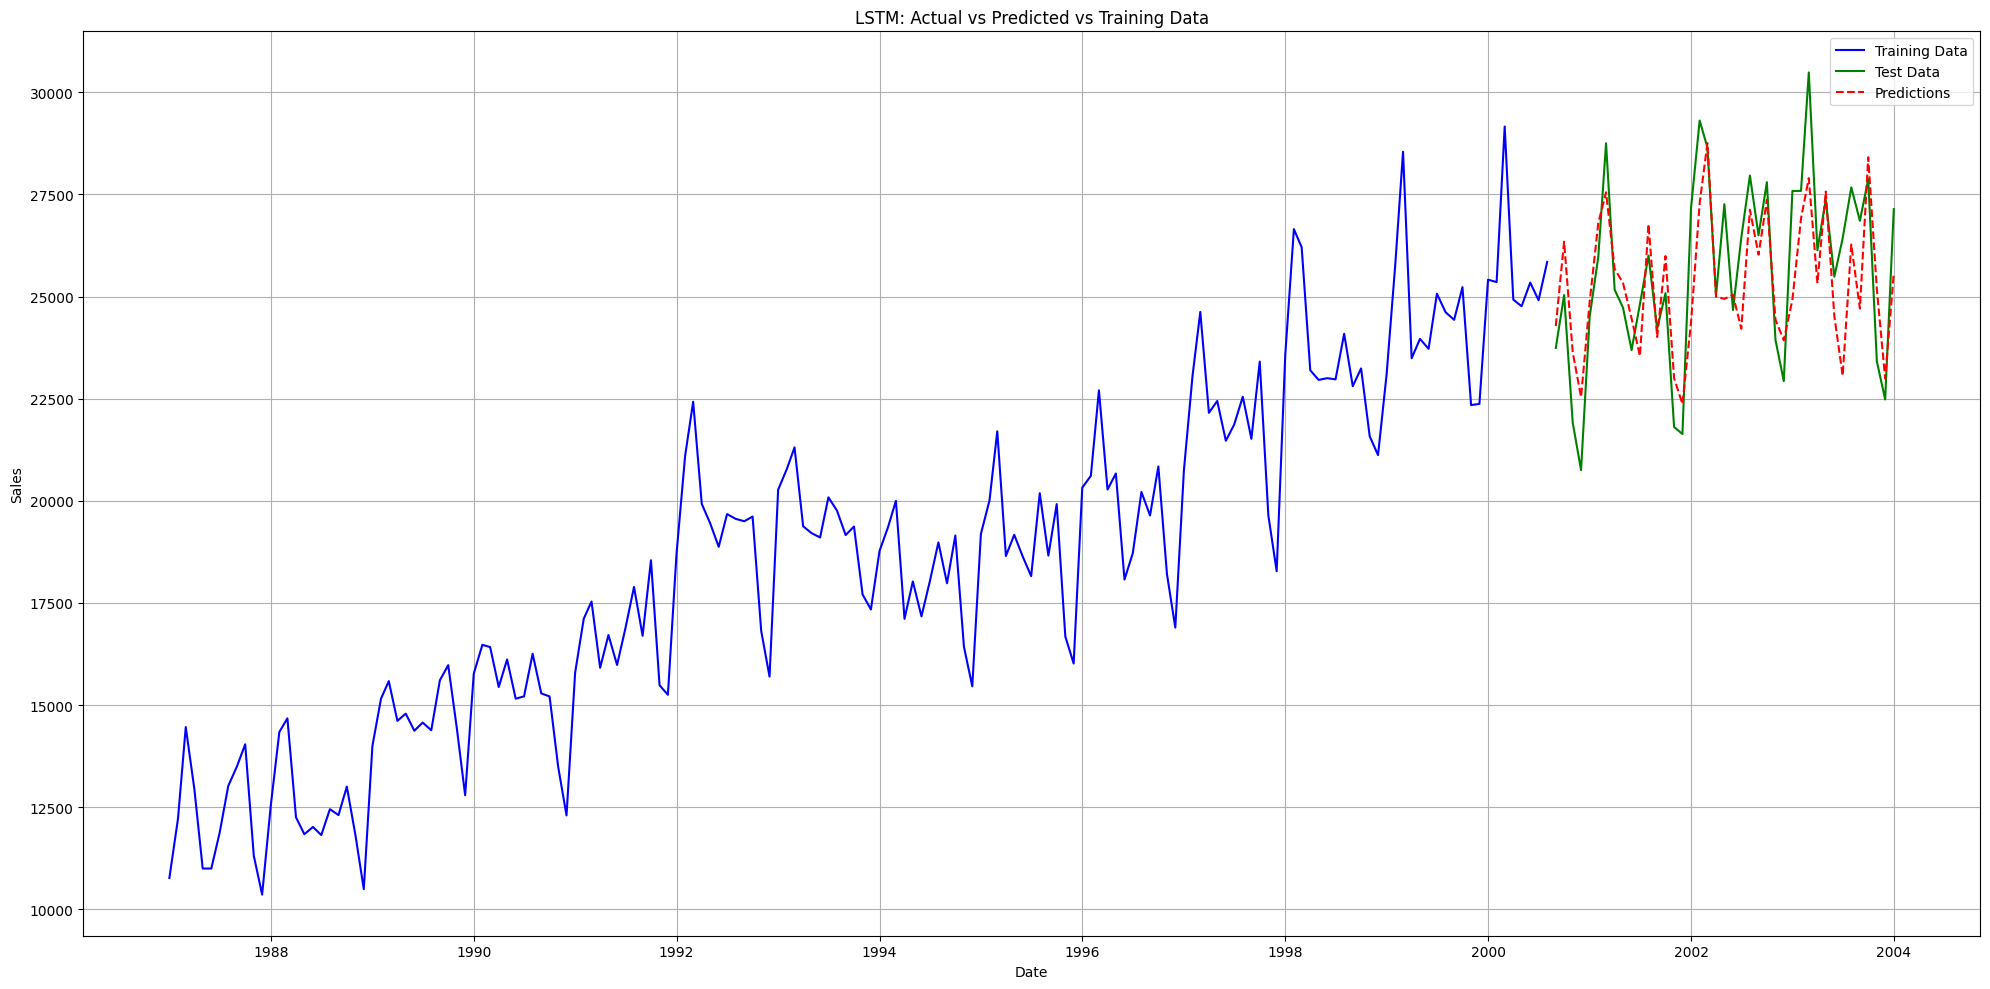

In [60]:
SEQ_LENGTH = 12
total_dates = data.index[SEQ_LENGTH:] 

train_size = len(y_train)
test_size = len(y_test)

train_dates = total_dates[:train_size]
test_dates = total_dates[train_size:]

plt.figure(figsize=(20, 10))

plt.plot(train_dates, y_train_rescaled, label="Training Data", color="blue")
plt.plot(test_dates, y_test_rescaled, label="Test Data", color="green")
plt.plot(test_dates, pred_rescaled, label="Predictions", color="red", linestyle='--')

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("LSTM: Actual vs Predicted vs Training Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



**Calculating rolling predictions**

In [61]:
rolling_preds = []
current_sequence = X_test[0]

for i in range(len(X_test)):
    pred = best_model.predict(current_sequence.reshape(1, SEQ_LENGTH, 1))[0][0]
    rolling_preds.append(pred)

    current_sequence = np.append(current_sequence[1: ], pred)

rolling_predictions = scalar.inverse_transform((np.array(rolling_preds)).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

**Calculating rolling residuals**

In [62]:
rolling_residuals = y_test_rescaled - rolling_predictions

**Visualising rolling residuals**

Text(0, 0.5, 'Error')

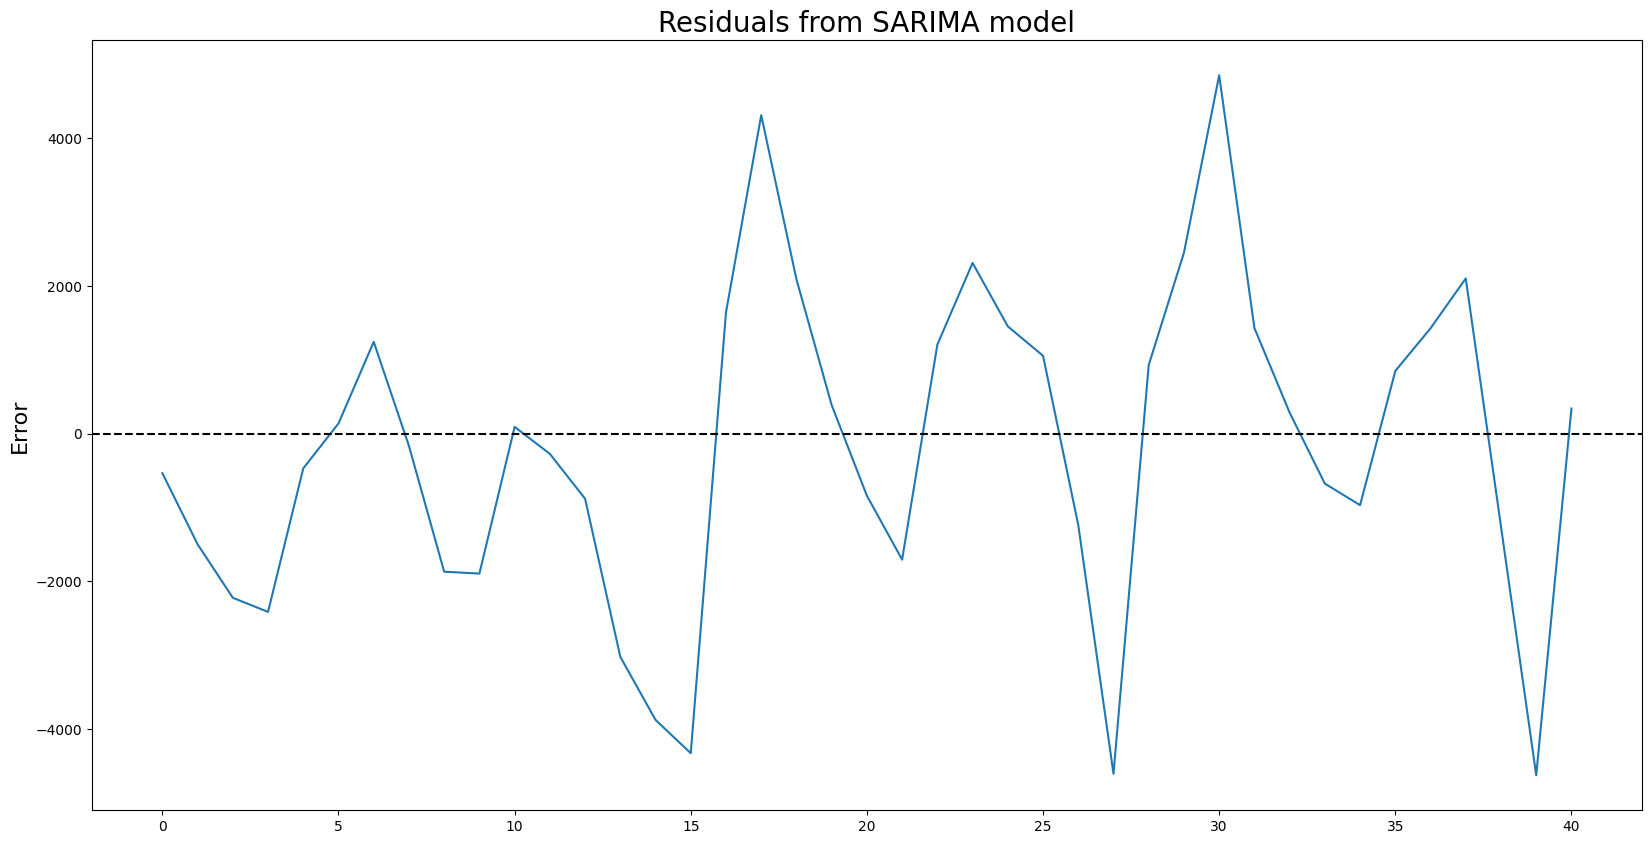

In [63]:
plt.figure(figsize=(20,10))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle = '--', color='k')
plt.title('Residuals from SARIMA model', fontsize=20)
plt.ylabel('Error', fontsize=16)

**Visualising the distribution of rolling residuals**

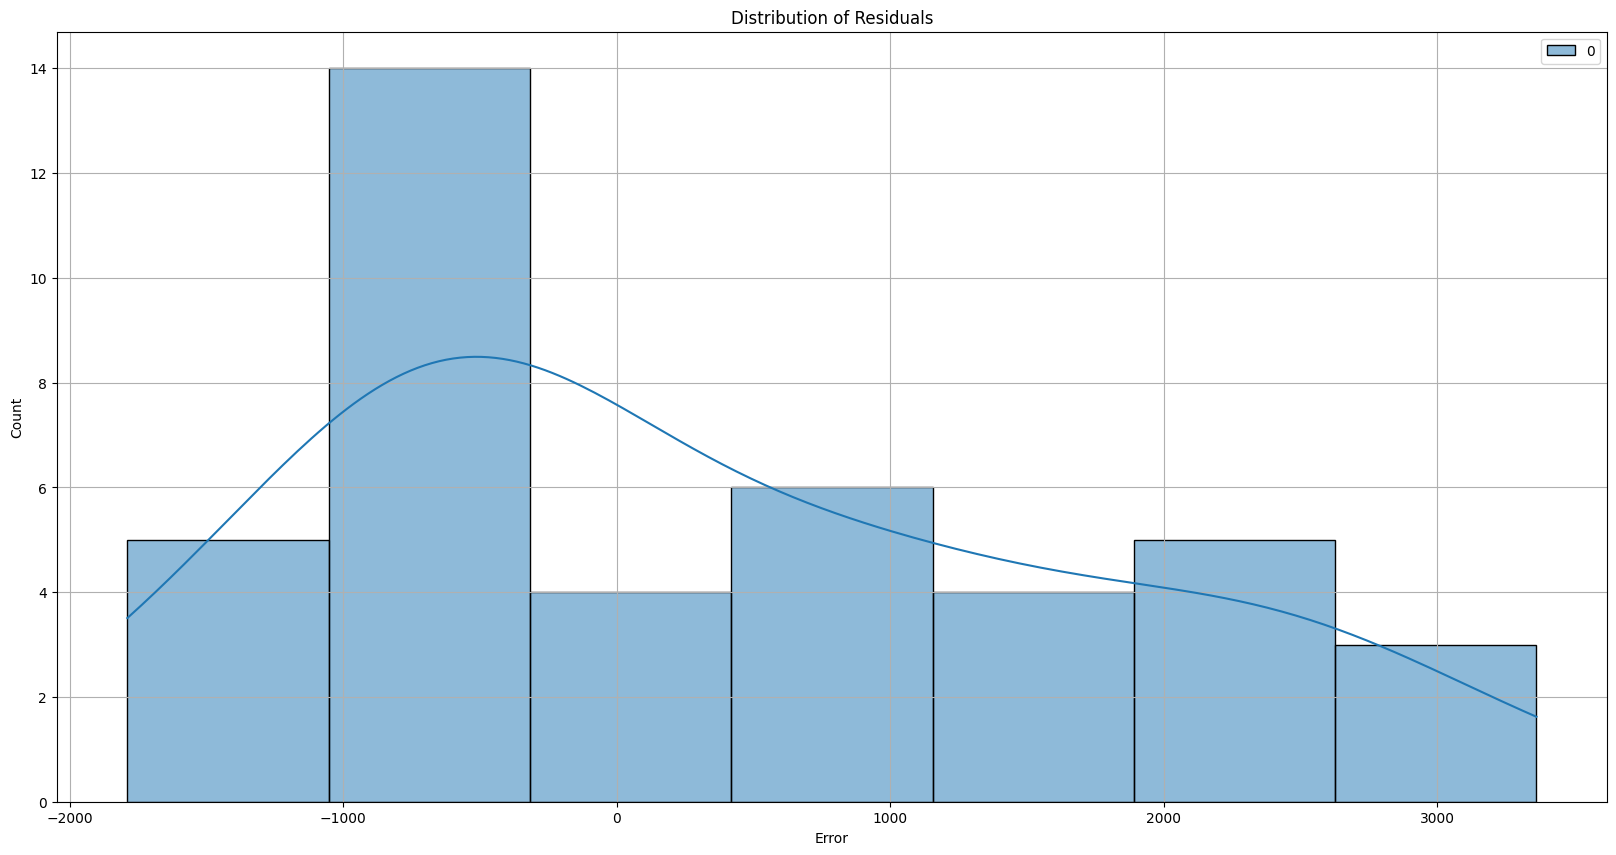

In [64]:
plt.figure(figsize=(20,10))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Error")
plt.grid(True)
plt.show()

**Calculating MAPE error metric**

In [65]:
print('Mean Absolute Percent error: ', round(np.mean(abs(rolling_residuals/y_test_rescaled)), 4))

Mean Absolute Percent error:  0.0681


**Displaying the rolling predictions**

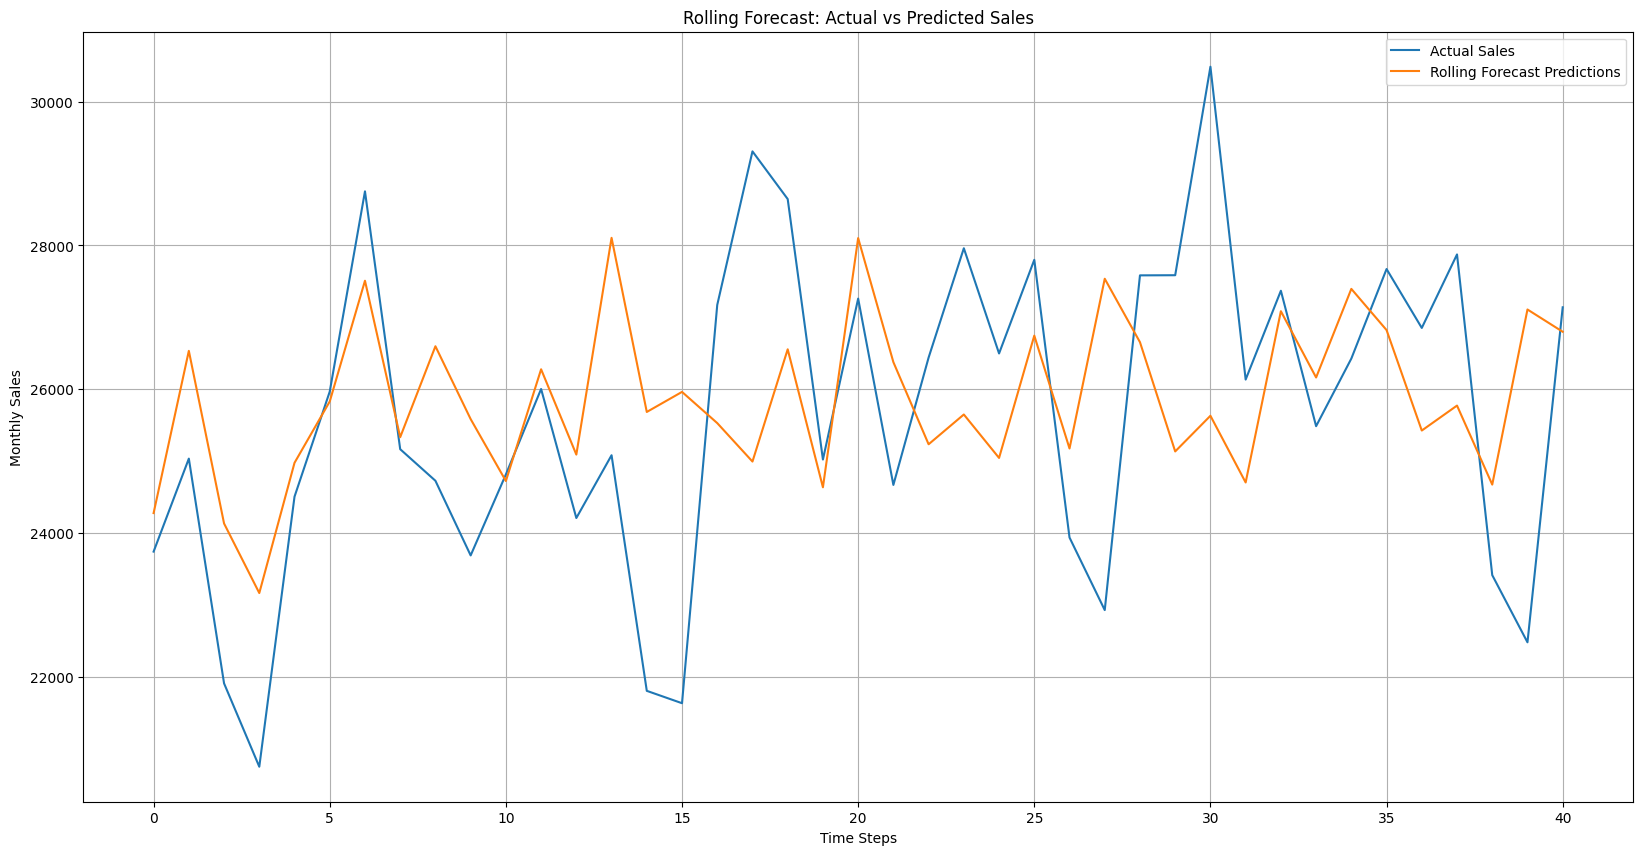

In [66]:
plt.figure(figsize=(20, 10))
plt.plot(y_test_rescaled, label='Actual Sales')
plt.plot(rolling_predictions, label='Rolling Forecast Predictions')
plt.title("Rolling Forecast: Actual vs Predicted Sales")
plt.xlabel("Time Steps")
plt.ylabel("Monthly Sales")
plt.legend()
plt.grid(True)
plt.show()

**Displaying the total dataset as well as the rolling predictions**

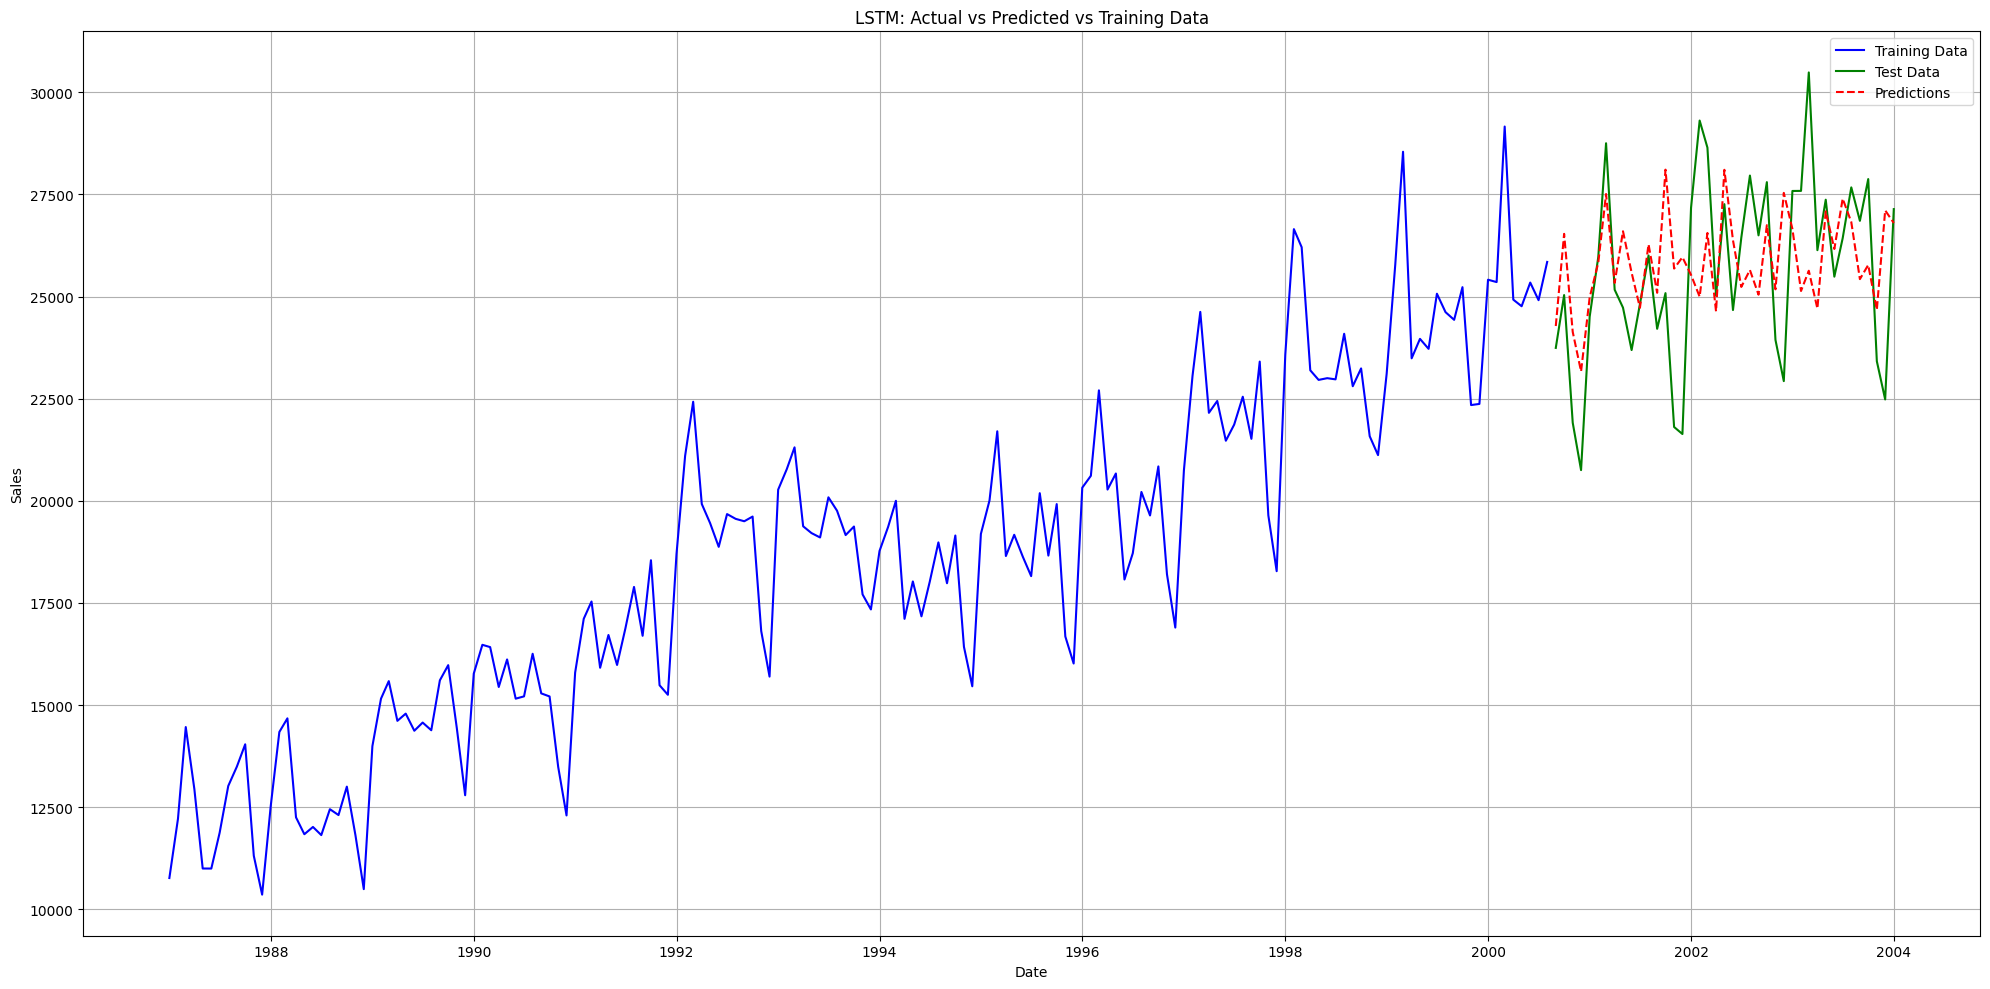

In [67]:
plt.figure(figsize=(20,10))
plt.plot(train_dates, y_train_rescaled, label="Training Data", color="blue")
plt.plot(test_dates, y_test_rescaled, label="Test Data", color="green")
plt.plot(test_dates, rolling_predictions, label="Predictions", color="red", linestyle='--')

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("LSTM: Actual vs Predicted vs Training Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()